# Consignas (Elegir una). Desafio: Usar GloVe, no vale usar transformers.
 1. Mejorar performance sin overfitting.
 2. Mejorar tiempo de entrenamiento sin haber perdido performance (import time)

## Preparación del Entorno y Datos

In [245]:
!pip install datasets --quiet
!pip install flair --quiet

In [246]:
import pandas as pd
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from flair.embeddings import WordEmbeddings
from flair.data import Sentence
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from flair.embeddings import WordEmbeddings
from flair.data import Sentence


# Fix the seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


## Preprocesamiento de Textos

In [247]:
# Load the dataset
df = load_dataset("dair-ai/emotion")

# Convertir cada parte del dataset a DataFrame de pandas 
train_df = df['train'].to_pandas()
val_df = df['validation'].to_pandas() 
test_df = df['test'].to_pandas()

# Combinar todo en un solo DataFrame:
combined_df = pd.concat([train_df, val_df, test_df])

### Profile Report

In [248]:
from ydata_profiling import ProfileReport
profile = ProfileReport(combined_df, title="Informe Exploratorio", explorative=True)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Eliminación de StopWords

In [249]:
# Eliminar palabras comunes y sin valor predictivo (ejemplo con stopwords de NLTK)
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

combined_df['text'] = combined_df['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/achula/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/achula/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


WordCloud Sin Stopwords

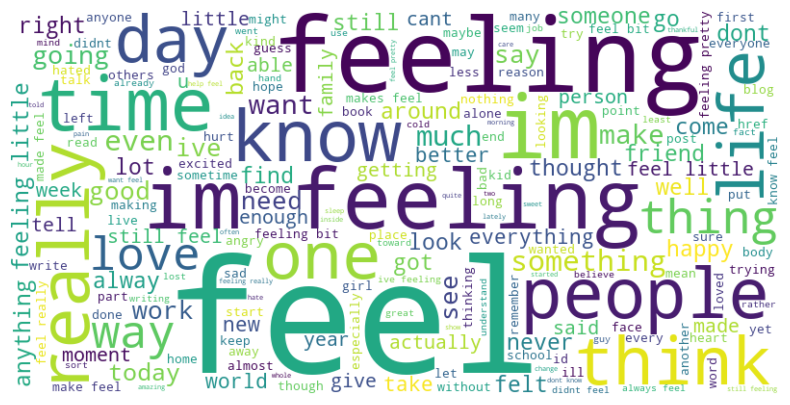

In [250]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from io import BytesIO
from PIL import Image

# Combina todos los textos en una sola cadena
text = " ".join(review for review in combined_df["text"])

# Genera la wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Guardar la wordcloud en un objeto BytesIO (esto es opcional, si necesitas trabajar con la imagen en bytes)
img_buffer = BytesIO()
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig(img_buffer, format='png')
plt.show()  # Muestra la WordCloud directamente en el notebook

### GloVe Embedding

In [251]:
# Inicializa el modelo de embedding GloVe
glove_embedding = WordEmbeddings('glove')

# Define un mapeo de emociones a etiquetas numéricas
emotion_to_label = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}


def embed_sentence(sentence_text, glove_embedding):
    sentence = Sentence(sentence_text)
    glove_embedding.embed(sentence)

    token_embeddings = []
    for token in sentence:
        token_embeddings.append(token.embedding)

    embeddings = torch.stack(token_embeddings) if token_embeddings else torch.empty(0)

    return embeddings

### Re Sampling (failure)

Se realizó un experimento de over y undersampling, pero como no se observaron mejoras en los resultados, se decidió no incluir estas técnicas en el trabajo.

## Funciones de Perdida

### Focal Loss

In [254]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, reduction='mean'):
        """
        gamma: Focusing parameter, typically 2.0 or 1.0.
        alpha: Class balancing factor, if specified (Tensor of shape [num_classes]).
        reduction: Specifies the reduction to apply to the output ('none', 'mean', 'sum').
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, logits, target):
        # Compute cross entropy loss
        ce_loss = F.cross_entropy(logits, target, reduction='none')

        # Compute p_t
        pt = torch.exp(-ce_loss)

        # Compute Focal Loss
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        # Apply class balancing if alpha is specified
        if self.alpha is not None:
            alpha_t = self.alpha.gather(0, target)
            focal_loss = alpha_t * focal_loss

        # Apply reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

Se observó que las clases minoritarias tenían un rendimiento significativamente inferior. Por ello, se decidió implementar la Focal Loss, ya que esta función de pérdida está diseñada para enfocarse más en los ejemplos difíciles, como los de las clases menos representadas.

Durante el entrenamiento con Focal Loss, se notó una reducción en la pérdida de validación, lo que indica que el modelo estaba aprendiendo mejor en general. Sin embargo, también se observó una disminución en la precisión global del modelo. Para abordar este problema, se propuso utilizar una función de pérdida híbrida (Hybrid Loss), que combina Focal Loss con Cross-Entropy Loss, con el objetivo de equilibrar la mejora en las clases minoritarias sin comprometer la precisión general del modelo.

### Hybrid Loss

La Hybrid Loss es una función de pérdida que combina dos funciones de pérdida diferentes, como Focal Loss y Cross-Entropy Loss, para aprovechar los beneficios de ambas. Su objetivo es mejorar la capacidad del modelo para manejar clases desbalanceadas (gracias a Focal Loss) mientras se mantiene la precisión general (gracias a Cross-Entropy Loss). Esto se logra ponderando ambas pérdidas de manera controlada durante el entrenamiento.

In [255]:
class HybridLoss(nn.Module):
    def __init__(self, alpha=0.5, gamma=2.0, weights=None):
        super(HybridLoss, self).__init__()
        self.focal_loss = FocalLoss(gamma=gamma, alpha=weights)
        self.ce_loss = nn.CrossEntropyLoss(weight=weights)
        self.alpha = alpha

    def forward(self, logits, targets):
        return self.alpha * self.focal_loss(logits, targets) + (1 - self.alpha) * self.ce_loss(logits, targets)

## Train y Test Split

In [256]:
# Convierte las Series de pandas a arrays de NumPy
train_texts = combined_df['text'].values
train_labels = combined_df['label'].values

sentiment_dataset = SentimentDataset(train_texts, train_labels, glove_embedding)
train_dataset, val_dataset = train_test_split(sentiment_dataset, test_size=0.4, random_state=42)


In [257]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

## Construcción de Modelos

### Sentiment Dataset

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, glove_embedding):
        self.texts = texts
        self.labels = labels
        self.glove_embedding = glove_embedding

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        embeddings = embed_sentence(text, self.glove_embedding)

        #padding - relleno de espacios para que todos los embeddings tengan el mismo length
        padded_embeddings = torch.zeros(70, self.glove_embedding.embedding_length)
        if embeddings.nelement() > 0:
            padded_embeddings[:len(embeddings), :] = embeddings

        return padded_embeddings, torch.tensor(label, dtype=torch.long)

### Early Stopping

In [ ]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

### Red Neuronal Convolucional 

In [197]:
from tqdm import tqdm

In [198]:
class CNNSentimentClassifier(nn.Module):
    def __init__(self, embedding_dim, num_filters, filter_sizes, num_classes, dropout=0.5):
        super(CNNSentimentClassifier, self).__init__()

        # Crear una lista de capas convolucionales con diferentes tamaños de filtro
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs) for fs in filter_sizes
        ])

        # Capa lineal para la clasificación final
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

        # Dropout para regularización
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Reordenar el tensor de entrada para que tenga la forma (batch_size, embedding_dim, seq_len)
        x = x.permute(0, 2, 1)

        # Aplicar convoluciones y activación ReLU
        conv_outputs = [F.relu(conv(x)) for conv in self.convs]

        # Aplicar max pooling a lo largo de la dimensión de la secuencia
        pooled = [F.max_pool1d(output, kernel_size=output.shape[2]).squeeze(2) for output in conv_outputs]

        # Concatenar las salidas de todos los filtros
        cat = torch.cat(pooled, dim=1)

        # Aplicar dropout y capa lineal final
        x = self.dropout(cat)
        x = self.fc(x)

        return x

## Entrenamiento

### CNN Entrenamiento

In [225]:
### RUN THE CNN

# Initialize the model
embedding_dim = 100
num_epochs = 20
num_filters = 100
filter_sizes = [3, 4, 5]
num_classes = len(emotion_to_label)
model = CNNSentimentClassifier(embedding_dim, num_filters, filter_sizes, num_classes, dropout=0.4)

# Calculate class weights
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
class_weights = total_samples / (len(emotion_to_label) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float)

# Set up criterion, optimizer, and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Calculate class weights. con el fin de tratar el desbalance de clases.
class_counts = np.bincount(train_labels)
total_samples = len(train_labels)
class_weights = total_samples / (len(emotion_to_label) * class_counts)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)  # Move to device first

# Initialize the criterion with weights already on the correct device
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# Inicializar Focal Loss con los pesos de las clases
# criterion = FocalLoss(gamma=1.0, alpha=class_weights_tensor)

# Inicializar Hybrid Loss con los pesos de las clases
criterion = HybridLoss(alpha=0.7, gamma=2.0, weights=class_weights_tensor)


# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0001)

# Inicializar el scheduler ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

# EarlyStopping utility
early_stopper = EarlyStopping(patience=5, min_delta=0.01)

# Training and Validation Losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    tqdm_train_loader = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [TRAIN]", leave=False)
    for batch_embeddings, batch_labels in tqdm_train_loader:
        batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_embeddings)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    tqdm_val_loader = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [VAL]", leave=False)
    with torch.no_grad():
        for batch_embeddings, batch_labels in tqdm_val_loader:
            batch_embeddings, batch_labels = batch_embeddings.to(device), batch_labels.to(device)
            outputs = model(batch_embeddings)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_labels.size(0)
            correct += predicted.eq(batch_labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {correct/total:.4f}')

    # Actualizar el scheduler con la pérdida de validación
    scheduler.step(val_loss)

    early_stopper(val_loss)
    if early_stopper.early_stop:
        print("Early stopping triggered")
        break



Epoch 1/20, Train Loss: 0.9159, Val Loss: 0.5692, Val Acc: 0.6764


Epoch 2/20, Train Loss: 0.4811, Val Loss: 0.4615, Val Acc: 0.7309


Epoch 3/20, Train Loss: 0.3478, Val Loss: 0.3589, Val Acc: 0.7874


Epoch 4/20, Train Loss: 0.2835, Val Loss: 0.3469, Val Acc: 0.8075


Epoch 5/20, Train Loss: 0.2344, Val Loss: 0.3167, Val Acc: 0.8359


Epoch 6/20, Train Loss: 0.2022, Val Loss: 0.3036, Val Acc: 0.8277


Epoch 7/20, Train Loss: 0.1743, Val Loss: 0.3138, Val Acc: 0.8324


Epoch 8/20, Train Loss: 0.1547, Val Loss: 0.3328, Val Acc: 0.8383


Epoch 9/20, Train Loss: 0.1428, Val Loss: 0.3354, Val Acc: 0.8441


Epoch 10/20, Train Loss: 0.1051, Val Loss: 0.3536, Val Acc: 0.8506


Epoch 11/20, Train Loss: 0.0937, Val Loss: 0.3130, Val Acc: 0.8511
Early stopping triggered


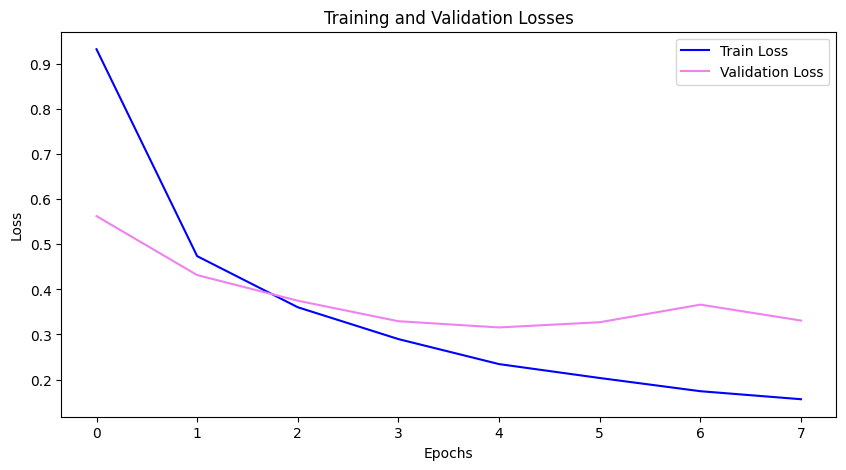

In [221]:
# Plotting train and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue')  
plt.plot(val_losses, label='Validation Loss', color='violet')  
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [226]:
def generate_classification_report_table(model, dataset, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for embeddings, labels in tqdm(dataset, desc="Generating predictions"):
            embeddings = embeddings.to(device)
            outputs = model(embeddings)
            _, predicted = outputs.max(1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate the classification report
    report = classification_report(all_labels, all_predictions, target_names=emotion_to_label.values(), output_dict=True)

    # Convert the report to a DataFrame
    df = pd.DataFrame(report).transpose()

    # Reorder the columns
    df = df[['precision', 'recall', 'f1-score', 'support']]

    # Format the values
    df['precision'] = df['precision'].apply(lambda x: f"{x:.6f}")
    df['recall'] = df['recall'].apply(lambda x: f"{x:.6f}")
    df['f1-score'] = df['f1-score'].apply(lambda x: f"{x:.6f}")
    df['support'] = df['support'].astype(int)

    # Print the table
    print(df.to_string())

# Add this to your main function or after training
def evaluate_model(model, val_dataset, device):
    val_loader = DataLoader(val_dataset, batch_size=32)
    generate_classification_report_table(model, val_loader, device)

# Call this function after training your model
evaluate_model(model, val_dataset, device)

Generating predictions: 100%|██████████| 250/250 [00:11<00:00, 22.69it/s]


             precision    recall  f1-score  support
sadness       0.870210  0.896815  0.883312     2355
joy           0.927585  0.825326  0.873473     2685
love          0.702337  0.847181  0.767989      674
anger         0.856757  0.869287  0.862976     1094
fear          0.796703  0.803769  0.800221      902
surprise      0.666667  0.806897  0.730109      290
accuracy      0.851125  0.851125  0.851125        0
macro avg     0.803376  0.841546  0.819680     8000
weighted avg  0.857817  0.851125  0.852591     8000
